# <center> Rainfall Prediction <center/>
   <img src="./Downloads/pic.jpg" width="100%" height="4%">

## Outline
- Importing important libraries
- Loading data using Pandas Library
- Exploratory Data Analysis
- Feature Engineering and Feature Selection
- Building a complete Data Processing Pipeline
- Model Training and Evaluation using ROC_AUC curve

## 1. Import important libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Load data using pandas

In [3]:
weather_data = pd.read_csv('D:/sqldatasets/WeatherAUS.csv')

In [4]:
#Displaying the first 5 records of the data
weather_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## 3. Exploratory Data Analysis(EDA)

## 3.1 .Size of the dataset

In [5]:
print('No. of records in the dataset:',weather_data.shape[0])
print('No. of variables in the dataset:',weather_data.shape[1])

No. of records in the dataset: 145460
No. of variables in the dataset: 23


Due to the large size of the dataset, the data would be splitted using the train_test_split method instead of using Cross_Validation.

## 3.2 Types of information found in the dataset

In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## 3.3 NaN detection

Text(0.5, 0, 'missing_percent')

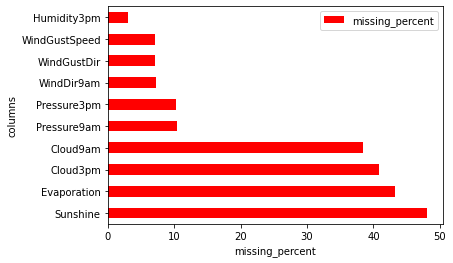

In [7]:
# Identifying the percentage of missing values per column

def missing_percent(weather_data):
    missing_info = pd.DataFrame(np.array(weather_data.isnull().sum().sort_values(ascending = False).reset_index()),
                  columns = ['columns','missing_percent']).query('missing_percent > 0').set_index('columns')
    return np.round(100*missing_info/weather_data.shape[0],2)
    
missing_percent(weather_data)[:10].plot(kind = 'barh', color = 'r')
plt.xlabel('missing_percent')

In [8]:
missing_percent(weather_data)[:10]

,missing_percent
columns,
Sunshine,48.009762
Evaporation,43.166506
Cloud3pm,40.807095
Cloud9am,38.421559
Pressure9am,10.356799
Pressure3pm,10.331363
WindDir9am,7.263853
WindGustDir,7.098859
WindGustSpeed,7.055548


## 3.4 Checking whether the dataset is balanced or not 

Checking whether the dataset is balanced or not will enable one  
- To select an appropriate evaluation metrics to use
- To whether he/she is going to balance the data through sampling or other means.
- To select an appropriate machine learning model for the project.

In [9]:
weather_data['RainTomorrow'].value_counts(normalize = True)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

Text(0, 0.5, 'counts')

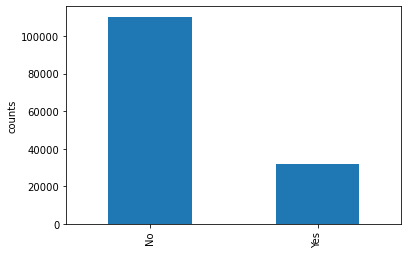

In [10]:
weather_data['RainTomorrow'].value_counts().plot(kind = 'bar')
plt.ylabel('counts')

- About 76% of data consist of No while 22% consist of yes. Thus the dataset is imbalanced.
- Because the dataset is imbalanced the suitable evaluation metrics to use is F1-Score(Harmonic mean of Recall and Precision).
- Tree algorithms would be suitable for this task.

## 3.5 Identification of numerical and Categorical features

### Numerical features

In [11]:
numeric_features = weather_data.select_dtypes(exclude = 'object').columns.tolist()
print('No. of numerical_features:',len(numeric_features))
print('\n')
print('Numeric_features:',numeric_features)

No. of numerical_features: 16


Numeric_features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


### Discrete numeric features

In [12]:
discrete_features = [feature for feature in numeric_features if len(weather_data[feature].unique())<25]
print('Discrete features:',discrete_features)
print('No. of discrete features',len(discrete_features))

Discrete features: ['Cloud9am', 'Cloud3pm']
No. of discrete features 2


### Continuous features

In [13]:
continuous_features = [feature for feature in numeric_features if feature not in discrete_features ]
print('No.of continous features:',len(continuous_features))

No.of continous features: 14


### Categorical features

In [14]:
categorical_features = weather_data.select_dtypes(include = 'object').columns.tolist()
categorical_features = [feature for feature in categorical_features if feature not in ['Date']]
print('No. of numerical_features:',len(categorical_features))
print('\n')
print('Numeric_features:',categorical_features)

No. of numerical_features: 6


Numeric_features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


## 3.6 Understanding the distribution of input features

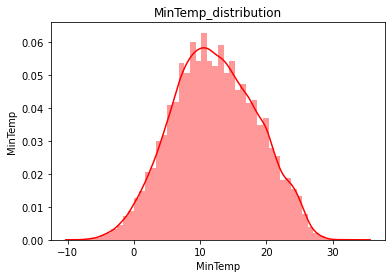

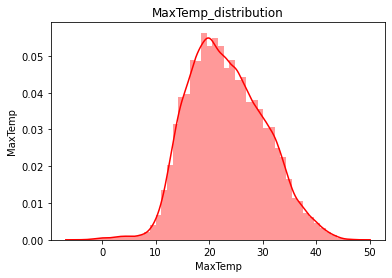

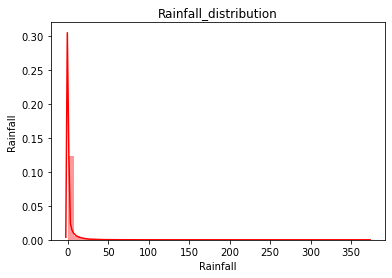

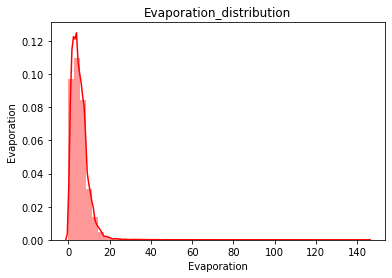

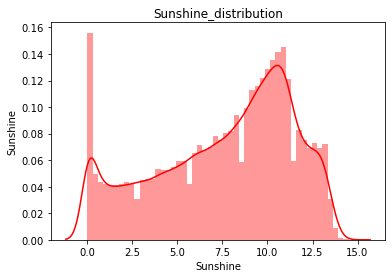

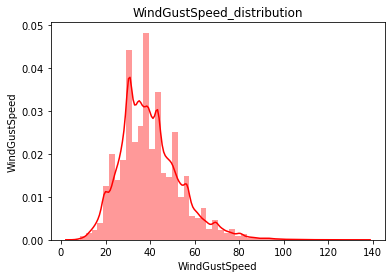

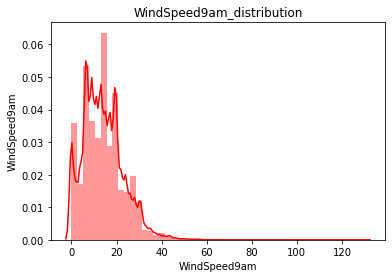

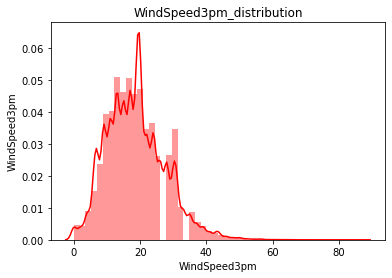

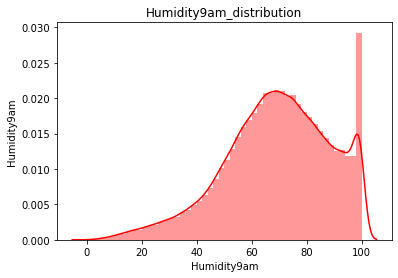

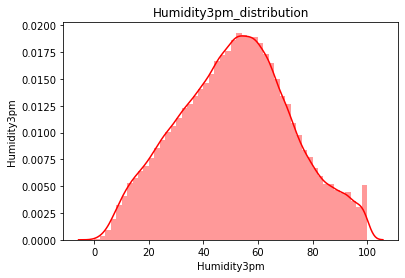

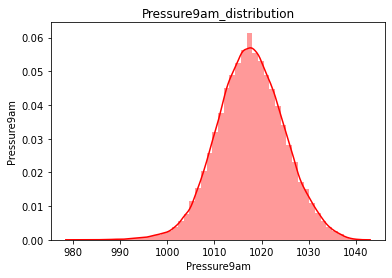

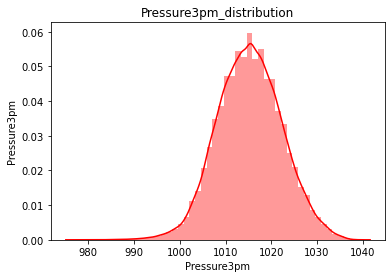

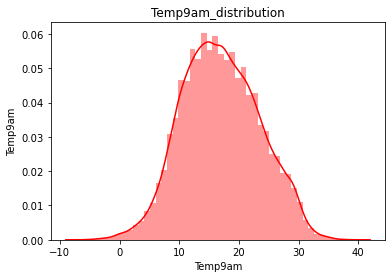

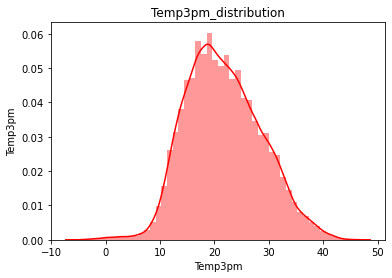

In [15]:
for feature in continuous_features:
    sns.distplot(weather_data[feature],kde = True,color = 'r')
    plt.ylabel(feature)
    plt.title('{}_distribution'.format(feature))
    plt.show()

From the above visualization, features such as _winspeed9am_,_sunshine_,_Rainfall_ are skewed.

## 3.6  Understanding the relationship between input features and target variable

####  Temperature vs RainTomorrow

<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

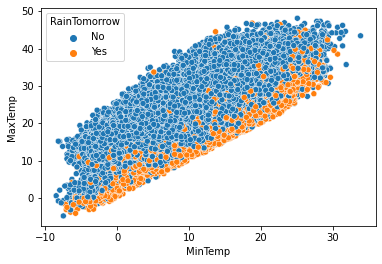

In [16]:
sns.scatterplot(x = 'MinTemp',y='MaxTemp',hue = 'RainTomorrow',data = weather_data)

It could be observed from the above visualization that temperatures increases the chances of having rain drops. For low MinTemp(between -7 and -4 degrees celsius) the probabilities of having rain or no rain is almost the same. 

#### Year vs no. of rainy days 

Text(0.5, 0, 'No. of rainy days')

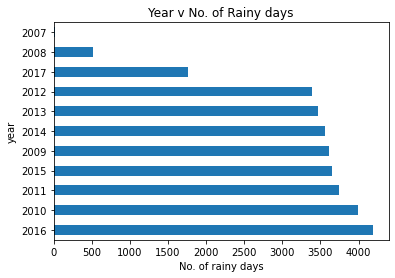

In [17]:
import datetime as dt 
rainy_df = weather_data[weather_data['RainTomorrow']== 'Yes']
pd.to_datetime(rainy_df['Date']).dt.year.value_counts().plot(kind = 'barh')
plt.title('Year v No. of Rainy days')
plt.ylabel('year')
plt.xlabel('No. of rainy days')

#### Year vs no. of non rainy days

Text(0.5, 0, 'No. of non rainy days')

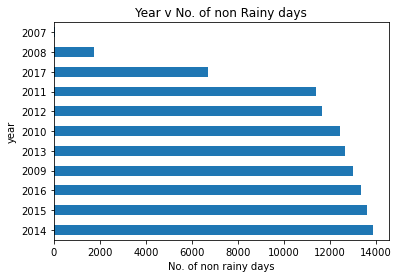

In [18]:
non_rainy_df = weather_data[weather_data['RainTomorrow']== 'No']
pd.to_datetime(non_rainy_df['Date']).dt.year.value_counts().plot(kind = 'barh')
plt.title('Year v No. of non Rainy days')
plt.ylabel('year')
plt.xlabel('No. of non rainy days')

#### Location vs Raindays

Text(0, 0.5, 'counts')

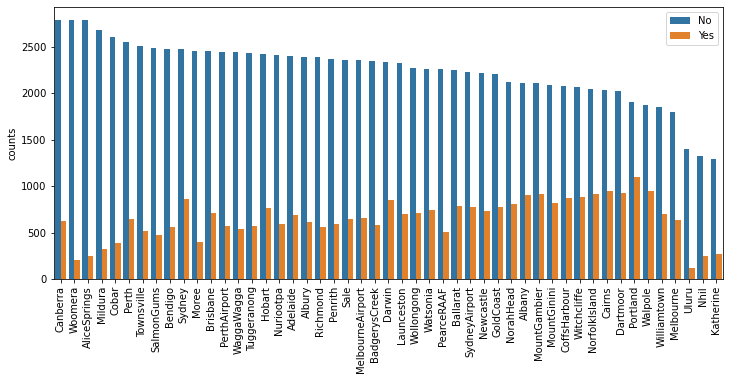

In [19]:
RainTomo = []
locat = []
groupdata = weather_data.groupby('RainTomorrow')['Location'].value_counts().sort_values(ascending = False)
for i in range(len(groupdata)):
    RainTomo.append(groupdata.index[i][0])
    locat.append(groupdata.index[i][1])
counts = groupdata.values
plt.figure(figsize = (12,5))
plt.xticks(rotation = 90)
sns.barplot(x = locat,y= counts,hue = RainTomo)
plt.ylabel('counts')

From the visualization above the number of rainy days and non-rainy days seems to be uniformly distributed accross the different locations in Australia.

### Temperature vs Humidity

In [20]:
weather_data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

<AxesSubplot:xlabel='MaxTemp', ylabel='Humidity3pm'>

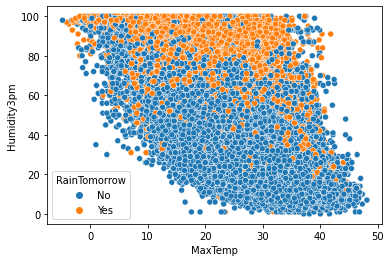

In [21]:
sns.scatterplot(x = 'MaxTemp', y = 'Humidity3pm', hue = 'RainTomorrow',data = weather_data )

- It could be observed from the above visualization that for higher humidity values the chances of having rainfall are high.

### Hypothesis Testing
This will involve using the _Chi-Square_ Test to find if there exist a signicance relation between
- RainToday and RainTomorrow
- Location and RainTomorrow

#### RainToday vs RainTomorrow


In [22]:
#create a contigency table
contigency_data = pd.crosstab(weather_data['RainToday'],weather_data['RainTomorrow'],margins = False )
contigency_data

RainTomorrow,No,Yes
RainToday,,
No,92728,16604
Yes,16858,14597


## NB:
In statistics, a contingency table is a type of table in a matrix format that displays the frequency distribution of the variables. They are heavily used in survey research, business intelligence.

In [23]:
#chi_square Testing
from scipy.stats import chi2_contingency
stats,p_value,dof,expected = chi2_contingency(contigency_data)
print('stats=%.7f  p=%.7f'%(stats,p_value))
if p_value>0.05:
    print('Independent variables')
else:
    print('Dependent variables')

stats=13799.4796493  p=0.0000000
Dependent variables


From the hypothesis testing performed above using Chi_Square Test, it shows that there exist a significance relationship between RainToday and RainTommorow

#### Location vs RainTomorrow 

In [24]:
#Creating contingency table using cross tabulation
contingency_data = pd.crosstab(weather_data['Location'],weather_data['RainTomorrow'],margins = False)

#Chi2_Test
stats,p_value,dof,expected = chi2_contingency(contingency_data)
print('stats = %.3f  p_value = %.3f'%(stats,p_value))
if p_value>0.05:
    print('independent variables')
else:
    print('Dependent variables')

stats = 3544.790  p_value = 0.000
Dependent variables


From the hypothesis testing performed above using Chi_Square Test, it shows that there exist a significance relationship between RainToday and RainTommorow

In [25]:
#strength of the correlation between RainToday and RainTomorrow.
RainToday = weather_data['RainToday'].map({'Yes': 1, 'No': 0})
RainTomorrow = weather_data['RainTomorrow'].map({'Yes': 1, 'No': 0})
correlation = np.round(RainToday.corr(RainTomorrow),2)
correlation

0.31

### Correlation Test

<AxesSubplot:>

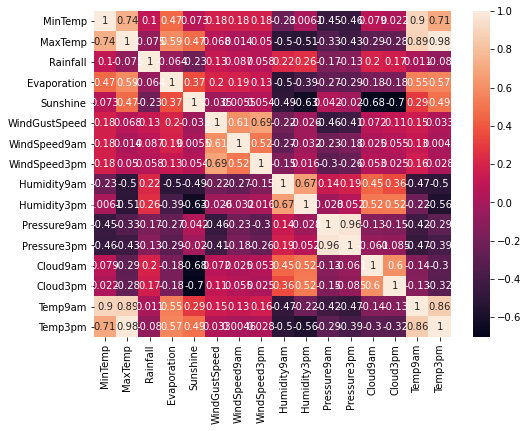

In [26]:
plt.figure(figsize = (8,6))
sns.heatmap(weather_data.corr(method = 'pearson'),annot = True)

From the correlation matrix above, the following features are highly correlated;
- MinTemp and Temp3pm
- MinTemp and Temp9am
- MaxTemp and Temp3pm
- MaxTemp and Temp9am
- Sunshine and Humidity3pm
- Sunshine and Humidity9am
- Sunshine and Cloud9am
- Sunshine and Cloud3pm

Thus to build a better model that will not overfit the training data, PCA would be used for dimensionality reduction which will result to independent features   that would be used to train the model.

### Statistical Summary

In [27]:
weather_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## 4. Feature Engineering and  Feature Selection

### 4.1 Creating of new features
Here new features will be created on the dataset using the date column.They will include;
- Year,
- Month and
- Day

In [28]:
weather_data['Year'] = pd.to_datetime(weather_data['Date']).dt.year
weather_data['Month'] = pd.to_datetime(weather_data['Date']).dt.month
weather_data['Day'] = pd.to_datetime(weather_data['Date']).dt.day
weather_data.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3


### 4.2 Dropping the date column

In [29]:
weather_data = weather_data.drop('Date',axis = True)

In [30]:
weather_data.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3


In [31]:
##Checking if the target column contains Missing values
weather_data['RainTomorrow'].isna().sum()

3267

In [32]:
#Dropping rows in which the target column contains missing values
weather_data.dropna(subset = ['RainTomorrow'],inplace = True)

#checking for missing values
weather_data['RainTomorrow'].isna().sum()

0

### 4.3 Splitting the dataset 

#### Input features and Target column

In [33]:
input_cols = [feature for feature in weather_data.columns if feature not in ['RainTomorrow']]
X = weather_data[input_cols]
Y = weather_data['RainTomorrow']

In [34]:
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,2008,12,5


#### Splitting the dataset in to train and Validation sets

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size = 0.2,random_state = 42)

In [36]:
X_train.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day
18401,NorahHead,15.1,23.9,0.0,NaN,NaN,SSW,67.0,NW,W,...,1001.9,1002.4,NaN,NaN,19.8,14.3,No,2009,10,14
127797,Walpole,9.7,14.2,7.6,NaN,NaN,WSW,50.0,WNW,W,...,1008.2,1007.7,NaN,NaN,11.1,13.4,Yes,2011,9,26
40012,Williamtown,13.2,25.4,0.0,3.2,8.8,ENE,30.0,W,E,...,1025.2,1021.5,6.0,5.0,21.2,24.0,No,2010,4,20


In [37]:
Y_train.head(3)

18401      No
127797    Yes
40012      No
Name: RainTomorrow, dtype: object

In [38]:
print('x_train_size:',len(X_train))
print('x_val_size:',len(X_val))

x_train_size: 113754
x_val_size: 28439


### 4.4 Data Preprocessing Pipeline
- Numerical features imputation and scaling
- One Hot Encoding of categorical features.

In [39]:
#Importing some data preprocessing libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [40]:
#Numerical columns
num_cols = X.select_dtypes(exclude = 'object').columns.tolist()

#categorical columns
cat_cols = X.select_dtypes(include = 'object').columns.tolist()

In [41]:
print(num_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']


In [42]:
#Numerical pipeline
numerical_pipeline = Pipeline([('numerical_imputer',SimpleImputer(strategy = 'median')),
                                ('feature_scaler',MinMaxScaler())])
#categorical_pipeline
categorical_pipeline = Pipeline([('categorical_imputer',SimpleImputer(strategy = 'most_frequent')),
                                ('categorical_encoder',OneHotEncoder(sparse = False))])
#column Transformer
column_pipeline = ColumnTransformer([('numerical_pipeline',numerical_pipeline,num_cols),
                                    ('categorical_pipeline',categorical_pipeline,cat_cols)])

In [43]:
proc_Xtrain = column_pipeline.fit_transform(X_train)
proc_xval = column_pipeline.fit_transform(X_val) 

In [44]:
proc_Xtrain.shape

(113754, 118)

In [45]:
Y_train = Y_train.map({'Yes':1,'No':0})
Y_val = Y_val.map({'Yes':1,'No':0})


In [46]:
Y_train

18401     0
127797    1
40012     0
130914    0
41742     0
         ..
112920    1
122810    0
106280    0
135107    1
124925    0
Name: RainTomorrow, Length: 113754, dtype: int64

### Feature Selection using PCA

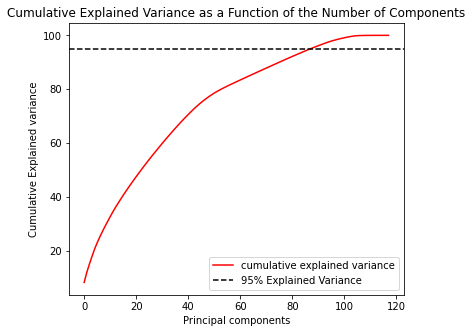

In [47]:
from sklearn.decomposition import PCA
pca = PCA().fit(proc_Xtrain)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(6, 5))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

From the commulative explained variance curve against number of principal components, the optimum number of principal components to which the data could be reduced to is about 90 PCs which explain atleast 95% variance in the data.

### Complete data preprocessing pipeline including PCA

In [48]:
#Complete ML pipeline including PCA
processing_pipeline = Pipeline([('column_pipeline',column_pipeline),
                    ('PCA',PCA(n_components = 90))])
#Data processing
x_train_processed = processing_pipeline.fit_transform(X_train)
x_val_processed = processing_pipeline.fit_transform(X_val)
x_train_processed 

array([[-1.97948369e-01,  7.35145779e-02,  1.02156096e-01, ...,
        -1.51275227e-01,  2.75993374e-01, -1.17416257e-01],
       [ 1.18413911e+00,  1.00226917e-02,  1.49593551e-01, ...,
        -1.17706594e-03, -1.17338091e-01,  2.22125034e-02],
       [-2.61225669e-01, -1.69258825e-01,  2.27119628e-02, ...,
         5.12456592e-01, -6.56395273e-02,  1.61202192e-01],
       ...,
       [-5.59715446e-01, -4.89589368e-01,  1.09768410e-01, ...,
         8.37127393e-03,  6.92530009e-02, -1.45649942e-01],
       [-1.73744323e-01, -1.68802247e-02,  1.52750675e-01, ...,
        -2.87852145e-01,  4.03841423e-02,  2.17842181e-01],
       [-4.17398112e-01, -3.78771835e-01, -5.49028388e-02, ...,
        -5.22444659e-02,  6.06259202e-02,  1.24826018e-01]])

In [49]:
x_train_processed.shape

(113754, 90)

## 5. Models Training and Evaluation

In [50]:
#Importing models to be used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [51]:
#Create a list of models to be trained and evaluated
models = []
models.append(('LR',LogisticRegression()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('KNN',KNeighborsClassifier()))

In [52]:
#Logistic Regression
model1 = LogisticRegression()
#Naive Bayes
model2 = GaussianNB()
#KNeighborsClassifier
model3  = KNeighborsClassifier(n_neighbors=4)

#Fitting the models into the data
model1.fit(x_train_processed,Y_train)
model2.fit(x_train_processed,Y_train)
model3.fit(x_train_processed,Y_train)

KNeighborsClassifier(n_neighbors=4)

In [55]:
#Prediction probabilities
pred_prob1 = model1.predict_proba(x_val_processed)
pred_prob2 = model2.predict_proba(x_val_processed)
pred_prob3 = model3.predict_proba(x_val_processed)

In [69]:
#Predictions
pred1 = model1.predict(x_val_processed)
pred2 = model2.predict(x_val_processed)
pred3 = model3.predict(x_val_processed)

In [57]:
#computing the ROC for the classifiers
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_val, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(Y_val, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh2 = roc_curve(Y_val, pred_prob3[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_val))]
p_fpr, p_tpr, _ = roc_curve(Y_val, random_probs, pos_label=1)

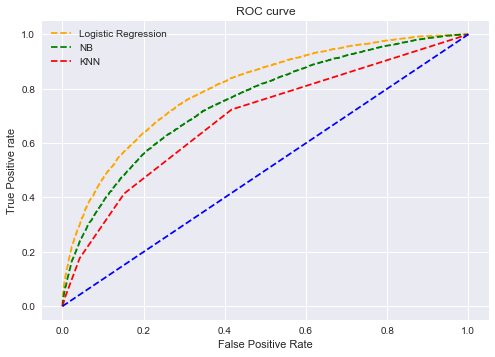

In [59]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='NB')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

In [72]:
#Calculating Precission, Recall,F1 and ROC_AUC scores

#Precissions
precision1 = precision_score(Y_val, pred1)
precision2 = precision_score(Y_val, pred2)
precision3 = precision_score(Y_val, pred3)
#Recall
recall1 = recall_score(Y_val, pred1) 
recall2 = recall_score(Y_val, pred2) 
recall3 = recall_score(Y_val, pred3) 
#F1_score
F1score1 = f1_score(Y_val, pred1)
F1score2 = f1_score(Y_val, pred2)
F1score3 = f1_score(Y_val, pred3)
# auc scores
auc_score1 = roc_auc_score(Y_val, pred_prob1[:,1])
auc_score2 = roc_auc_score(Y_val, pred_prob2[:,1])
auc_score3 = roc_auc_score(Y_val, pred_prob3[:,1])
#Dataframe
report_df = pd.DataFrame({'model':['LR','NB','KNN'],
                          'precision':[precision1,precision2,precision3],
                          'recall':[recall1,recall2,recall3],
                          'F1_score':[F1score1,F1score2,F1score3],
                          'AUC_score':[auc_score1,auc_score2,auc_score3]})

In [73]:
report_df

,model,precision,recall,F1_score,AUC_score
0,LR,0.604431,0.413026,0.490725,0.800746
1,NB,0.497598,0.441098,0.467648,0.750864
2,KNN,0.544747,0.176628,0.266762,0.689532


## Conclusion
Among the 3  models trained and evaluated using the data, LinearRegression is best due to it high AUC and F1 scores. This means that the model would be able to clearly distinguish between both classes as compared to the other 2 models.
